In [1]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from time import time
from typing import Callable, Tuple, Any

## Compression rates analysis

In [2]:
from src.lzw import lzw_compress, lzw_decompress
from src.lz77 import compress, decompress
from src.Huffman_algo import HuffmanCode
from src.deflate import Deflate

### Examples of values that would be returned

In [3]:
# Some data examples

# one sentence
one_sentence = np.array([ord(elm) for elm in 'TOBEORNOTTOBEORTOBEORNOT'])

# random testing text
with open('examples/text.txt') as infile:
    text = np.array([ord(char) for char in ''.join(infile.readlines())])

# random testing image
img = Image.open('examples/test_img.png').convert('RGB')
img = np.array(img, dtype='uint8')
img = np.ravel(img)    

In [4]:
print(compress(deepcopy(one_sentence)))

[( 0, 1, 84) ( 0, 1, 79) ( 0, 1, 66) ( 0, 1, 69) ( 3, 1, 79) ( 0, 1, 82)
 ( 0, 1, 78) ( 6, 1, 79) ( 8, 1, 84) ( 9, 6, 84) (15, 9, 84)]


In [5]:
print(lzw_compress(deepcopy(one_sentence)))

[  84   79   66   69   79   82   78   79   84  256  258  260  265  259
  261 7984]


In [6]:
code = HuffmanCode(deepcopy(one_sentence)).encode()
print(code)

('00110111001110101011000011011100111010011011100111010101100', {84: '00', 78: '010', 66: '011', 69: '100', 82: '101', 79: '11'})


In [7]:
code = Deflate().encode(deepcopy(one_sentence))
print(code)

Overall size of compression is: 956
[(1, {6: '00', 9: '01', 1: '1'}, '1111111110001', {3: '0000', 82: '0001', 78: '0010', 6: '0011', 8: '0100', 9: '0101', 79: '011', 0: '10', 15: '1100', 66: '11010', 69: '11011', 84: '111'}, '10111100111011010101101100000111000011000100011011010011101011111100111')]


In [8]:
def data_type_test(data: np.array):
    res = []
    
    # --- lz77 test ---
    start_time = time()
    compressed_data = compress(deepcopy(data))
    res.append(('lz77', sys.getsizeof(compressed_data), time() - start_time))
    assert np.all(data == decompress(compressed_data))
    
    # --- deflate test ---
    d = Deflate()
    start_time = time()
    compressed_data = d.encode(deepcopy(data))
    data_size: int = 0
    for elm in compressed_data:
        if elm[0] == 0:
            data_size += len(elm[1])
        elif elm[0] == 1:
            data_size += len(elm[2]) + len(elm[4]) + sys.getsizeof(elm[1]) + sys.getsizeof(elm[3])
    res.append(('deflate', data_size, time() - start_time))
    assert np.all(data == d.decode(compressed_data))
    
    # --- Huffman test ---
    h = HuffmanCode(deepcopy(data))
    start_time = time()
    compressed_data, table = h.encode()
    data_size = len(compressed_data) + sys.getsizeof(table)
    res.append(('huffman', data_size, time() - start_time))
    
    # --- lzw test ---
    start_time = time()
    compressed_data = lzw_compress(deepcopy(data))
    res.append(('lzw', sys.getsizeof(compressed_data), time() - start_time))
    
    return res

data_type_test(np.array([ord(elm) for elm in 'TOBEORNOTOTBEORTOBEORNOT']))

Overall size of compression is: 970


[('lz77', 228, 0.000885009765625),
 ('deflate', 970, 0.0012540817260742188),
 ('huffman', 419, 7.390975952148438e-05),
 ('lzw', 224, 0.0002162456512451172)]

In [9]:
def plot_test_data(data, data_type):
    print(f'Size of test {data_type} is {sys.getsizeof(list(data))}')
    rates = data_type_test(data)
    times_outstring = ''
    for elm in rates:
        times_outstring += f'{elm[0]}: {round(elm[-1], 2)}; '
    print(f'Time that each algo has taken to compress the thing: {times_outstring}')
    column_names = [elm[0] for elm in rates]
    data_sizes = [elm[1] for elm in rates]
    sns.barplot(x=column_names, y=data_sizes)
    plt.show()

    # in comparisson with raw text
    rates.insert(0, (f'raw {data_type}', sys.getsizeof(list(data)), None))
    column_names = [elm[0] for elm in rates]
    data_sizes = [elm[1] for elm in rates]
    sns.barplot(x=column_names, y=data_sizes)
    plt.show()


# Tests

Size of test one sentence is 248
Overall size of compression is: 956
Time that each algo has taken to compress the thing: lz77: 0.0; deflate: 0.0; huffman: 0.0; lzw: 0.0; 


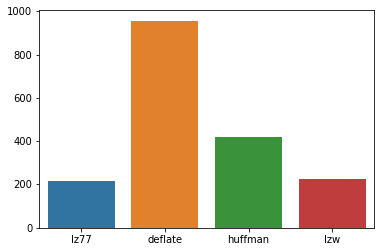

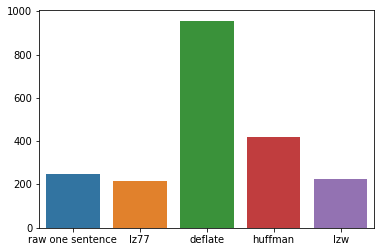

In [10]:
plot_test_data(one_sentence, 'one sentence')

Size of test text: Romeo and Juliet is 1396424
Overall size of compression is: 174546
Time that each algo has taken to compress the thing: lz77: 14.31; deflate: 20.4; huffman: 0.14; lzw: 0.39; 


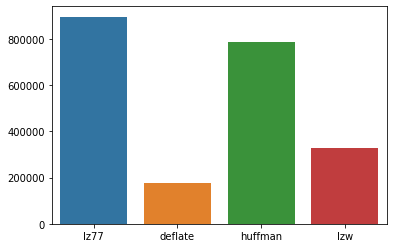

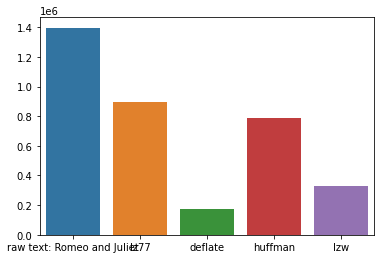

In [11]:
plot_test_data(text, 'text: Romeo and Juliet')

Size of test image is 11609048
Overall size of compression is: 129585
Time that each algo has taken to compress the thing: lz77: 12.72; deflate: 9.25; huffman: 0.95; lzw: 1.86; 


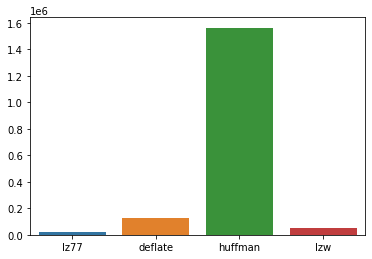

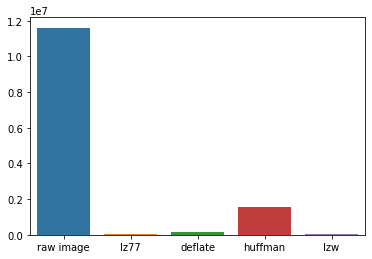

In [12]:
plot_test_data(img, 'image')